# Version information

In [2]:
from datetime import date
print("Running date:", date.today().strftime("%B %d, %Y"))
import pyleecan
print("Pyleecan version:" + pyleecan.__version__)
import SciDataTool
print("SciDataTool version:" + SciDataTool.__version__)

Running date: April 12, 2022
Pyleecan version:1.3.7
SciDataTool version:1.4.24


In [3]:
from os.path import join
import numpy as np
#from numpy.testing import assert_almost_equal

#import pytest

from SciDataTool.Functions.Plot.plot_2D import plot_2D
from SciDataTool.Functions.Plot.plot_3D import plot_3D

from pyleecan.Classes.OPdq import OPdq
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.VarLoadCurrent import VarLoadCurrent
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.PostLUT import PostLUT
from pyleecan.Classes.Electrical import Electrical
from pyleecan.Classes.EEC_PMSM import EEC_PMSM
from pyleecan.Functions.load import load
from pyleecan.Functions.Plot import dict_2D
from pyleecan.Functions.Electrical.dqh_transformation import (
    get_phase_dir_DataTime,
    n2dqh_DataTime,
)
from pyleecan.definitions import DATA_DIR
#from Tests import save_validation_path as save_path


# ELUT 생성

In [4]:
n_Id=5
n_Iq=5
Toyota_Prius = load(join(DATA_DIR, "Machine", "Toyota_Prius.json"))

# Generate ELUT
name = "test_EEC_ELUT_PMSM"
simu = Simu1(name=name, machine=Toyota_Prius)

# Definition of the input
simu.input = InputCurrent(
Nt_tot=8 * 12,
Na_tot=8 * 200,
OP=OPdq(N0=1000, Id_ref=0, Iq_ref=0),
)

# Build OP_matrix with a meshgrid of Id/Iq
Id_min, Id_max = -200, 200
Iq_min, Iq_max = -200, 200
Id, Iq = np.meshgrid(
np.linspace(Id_min, Id_max, n_Id), np.linspace(Iq_min, Iq_max, n_Iq)
)

In [5]:

OP_matrix = np.zeros((n_Id * n_Iq, 3))
OP_matrix[:, 0] = simu.input.OP.N0
OP_matrix[:, 1] = Id.ravel() #ravel() 다차원 배열 1차원 변환 함수
OP_matrix[:, 2] = Iq.ravel()

In [6]:
OP_matrix

array([[1000., -200., -200.],
       [1000., -100., -200.],
       [1000.,    0., -200.],
       [1000.,  100., -200.],
       [1000.,  200., -200.],
       [1000., -200., -100.],
       [1000., -100., -100.],
       [1000.,    0., -100.],
       [1000.,  100., -100.],
       [1000.,  200., -100.],
       [1000., -200.,    0.],
       [1000., -100.,    0.],
       [1000.,    0.,    0.],
       [1000.,  100.,    0.],
       [1000.,  200.,    0.],
       [1000., -200.,  100.],
       [1000., -100.,  100.],
       [1000.,    0.,  100.],
       [1000.,  100.,  100.],
       [1000.,  200.,  100.],
       [1000., -200.,  200.],
       [1000., -100.,  200.],
       [1000.,    0.,  200.],
       [1000.,  100.,  200.],
       [1000.,  200.,  200.]])

In [7]:
# Set varspeed simulation
simu.var_simu = VarLoadCurrent(
type_OP_matrix=1,
OP_matrix=OP_matrix,
is_keep_all_output=True,
stop_if_error=True,
)
# Define second simu for FEMM comparison
simu.mag = MagFEMM(is_periodicity_a=True, is_periodicity_t=True, nb_worker=16)

# For Postprocessing
simu.var_simu.postproc_list = [PostLUT(is_save_LUT=True)]

out = simu.run()

ELUT = out.simu.var_simu.postproc_list[0].LUT


[18:07:20] Starting running simulation test_EEC_ELUT_PMSM (machine=Toyota_Prius)
[18:07:20] Reference Operating point is not in OP_matrix, one extra simulation will be computed
[18:07:20] Computing reference simulation for Variable Load
[18:07:20] Starting Magnetic module
[18:07:21] Solving time step 1 / 12 in FEMM
[18:07:21] Solving time step 2 / 12 in FEMM
[18:07:21] Solving time step 5 / 12 in FEMM
[18:07:21] Solving time step 3 / 12 in FEMM
[18:07:21] Solving time step 4 / 12 in FEMM
[18:07:21] Solving time step 7 / 12 in FEMM
[18:07:22] Solving time step 6 / 12 in FEMM
[18:07:22] Solving time step 10 / 12 in FEMM
[18:07:22] Solving time step 8 / 12 in FEMM
[18:07:22] Solving time step 12 / 12 in FEMM
[18:07:22] Solving time step 11 / 12 in FEMM
[18:07:23] Solving time step 9 / 12 in FEMM
[18:07:24] Variable Load Reference Results: N0=1000 [rpm], Id=0 [Arms], Iq=0 [Arms], Tem_av=-0.0355 [N.m], Tem_rip_pp=0.1498 [N.m], Tem_rip_norm=-4.219 [-], Pem_av=-3.718 [W]
[=                   

<class 'list'>


C:\Users\user\.conda\envs\py38_pylee_backup\lib\site-packages\scidatatool-1.4.25-py3.8.egg\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\user\.conda\envs\py38_pylee_backup\lib\site-packages\scidatatool-1.4.25-py3.8.egg\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


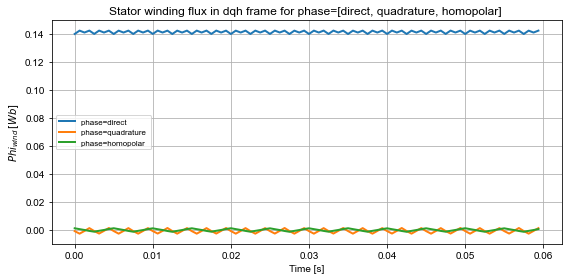

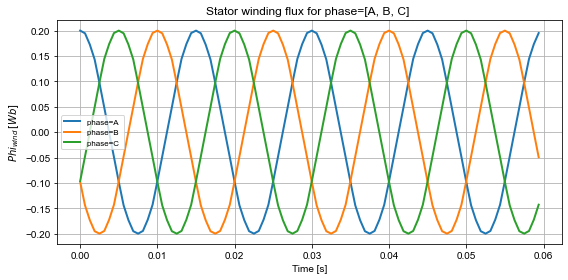

In [8]:
OP_list = OP_matrix[:, 1:3].tolist() # tolist list형태로 변환하는 method

ELUT = out.simu.var_simu.postproc_list[0].LUT
#ELUT1=out.simu.var_simu.postproc_list[1].LUT
Phi_dqh_mean = ELUT.get_Phidqh_mean()
Phi_dqh_mean.size
ii = OP_list.index([0, 0])  #[0,0 ]이 있는 위치 반환
print(type(OP_list))


# 무부하에서의 Phi_dqh0
Phi_dqh0 = n2dqh_DataTime(
    ELUT.Phi_wind[ii],
    is_dqh_rms=True,
    phase_dir=ELUT.get_phase_dir(),
)

Phi_dqh0_mean = Phi_dqh0.get_along("time=mean", "phase")[Phi_dqh0.symbol]

Phi_dqh0 = n2dqh_DataTime(
    ELUT.Phi_wind[ii],
    is_dqh_rms=True,
    phase_dir=ELUT.get_phase_dir(),
)


Phi_dqh0.plot_2D_Data(
"time",
"phase[]"
)

# ELUT.Phi_wind[1].plot_2D_Data(
# "time",
# "phase[]"
# )
ELUT.Phi_wind[ii].plot_2D_Data(
"time",
"phase[]"
)



In [9]:
type(ii)

int

C:\Users\user\.conda\envs\py38_pylee_backup\lib\site-packages\scidatatool-1.4.25-py3.8.egg\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\user\.conda\envs\py38_pylee_backup\lib\site-packages\scidatatool-1.4.25-py3.8.egg\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\user\.conda\envs\py38_pylee_backup\lib\site-packages\scidatatool-1.4.25-py3.8.egg\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\user\.conda\envs\py38_pylee_backup\lib\site-packages\scidatatool-1.4.25-py3.8.egg\SciDataTool\Functions\Plot\plot_2D.py:443: Us

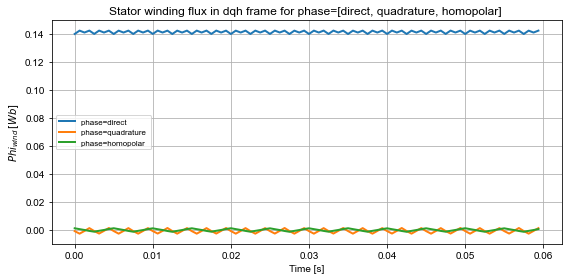

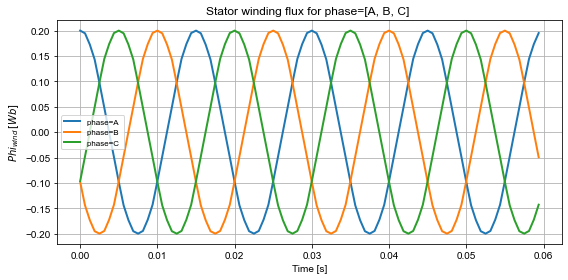

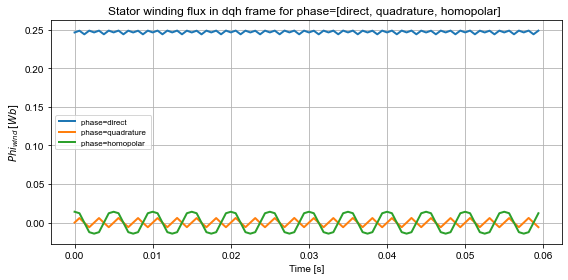

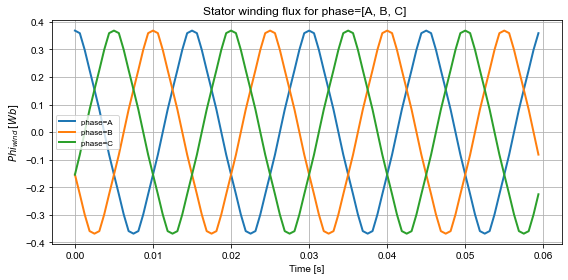

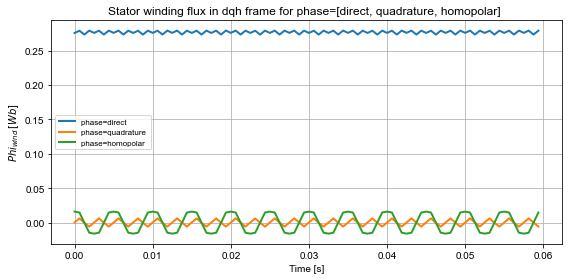

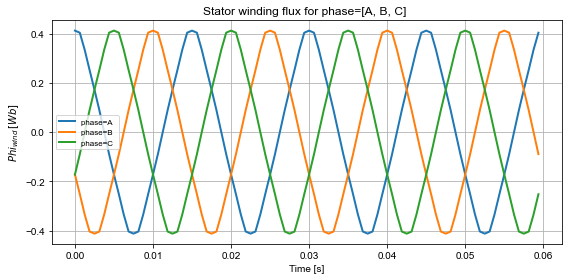

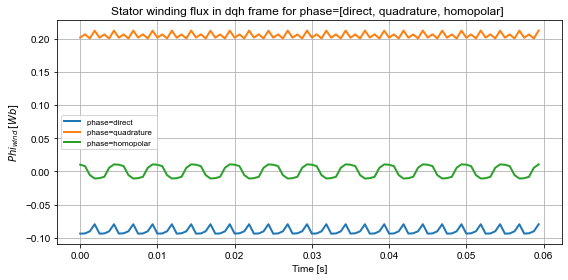

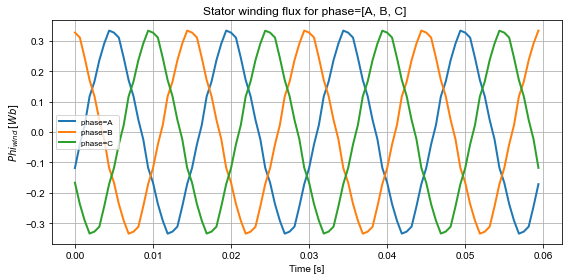

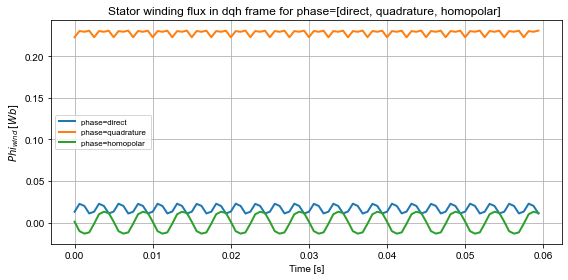

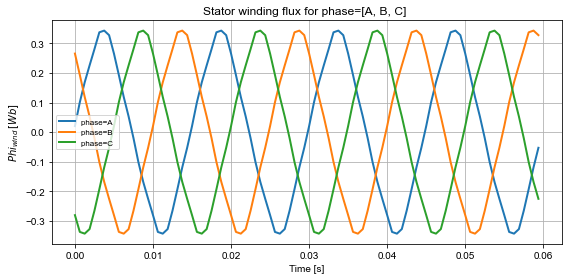

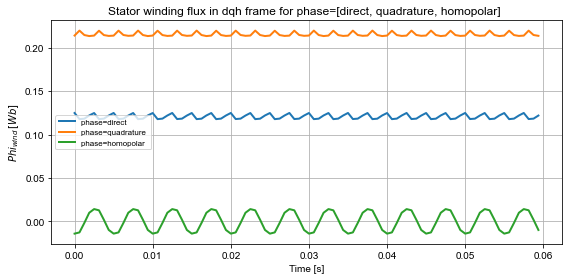

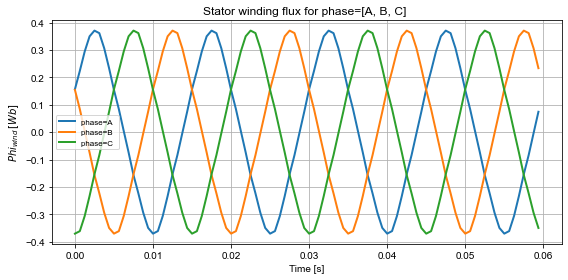

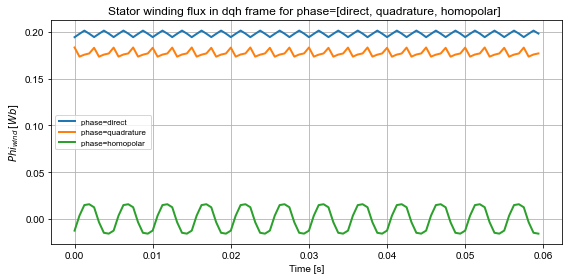

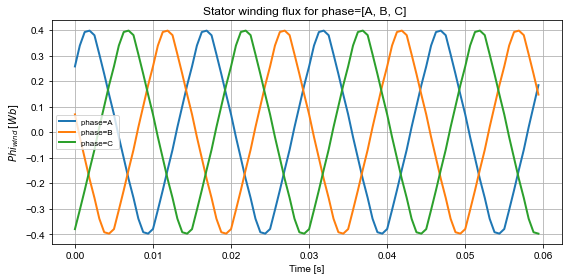

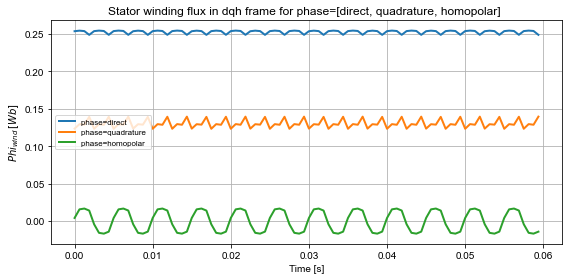

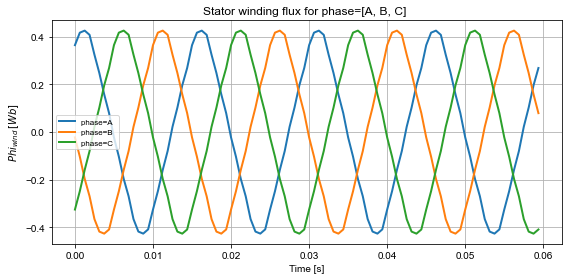

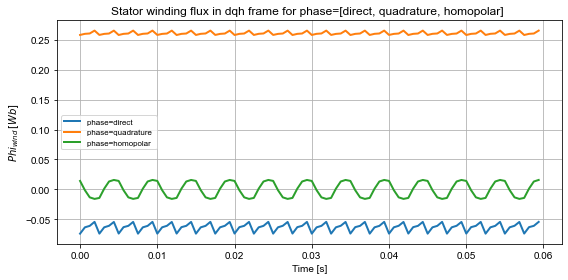

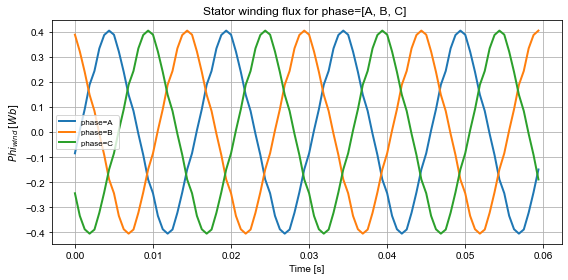

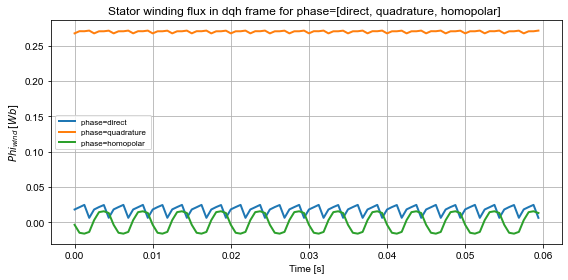

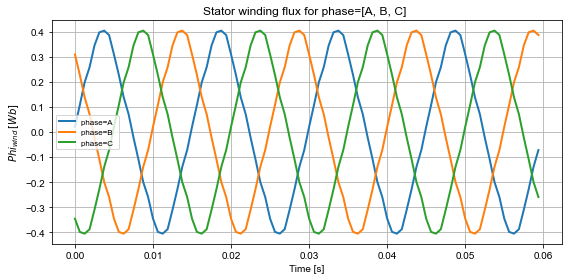

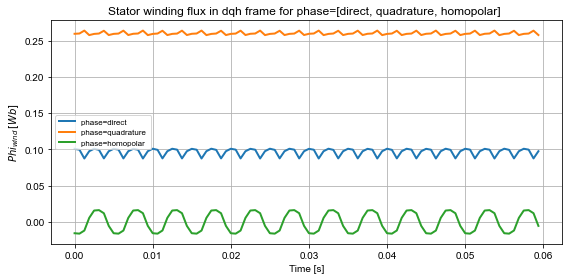

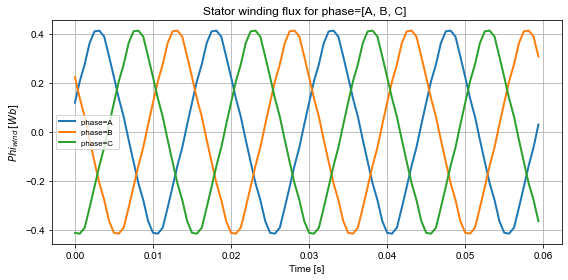

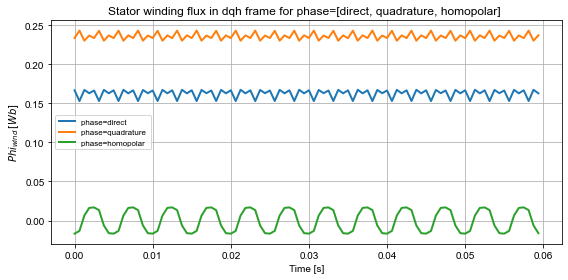

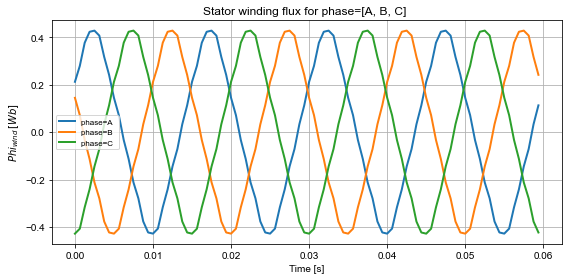

In [10]:
# Phi_dqh0.plot_2D_Data("time")
for ii in range(12, 24):
    Phi_dqh0 = n2dqh_DataTime(
        ELUT.Phi_wind[ii],
        is_dqh_rms=True,
        phase_dir=ELUT.get_phase_dir(),
    )


    Phi_dqh0.plot_2D_Data(
    "time",
    "phase[]"
    )

    # ELUT.Phi_wind[1].plot_2D_Data(
    # "time",
    # "phase[]"
    # )
    ELUT.Phi_wind[ii].plot_2D_Data(
    "time",
    "phase[]"
    )

In [11]:
ELUT = out.simu.var_simu.postproc_list[0].LUT
test_ELUT=ELUT

## MTPA 

In [12]:
"""Validation of the PMSM Electrical Equivalent Circuit with the Prius machine for MTPA calculation"""

n_Id=51
n_Iq=101
Toyota_Prius = load(join(DATA_DIR, "Machine", "Toyota_Prius.json"))
qs = Toyota_Prius.stator.winding.qs
p = Toyota_Prius.get_pole_pair_number()
Tsta = 20  # stator winding temperature
print(p)

4


In [13]:
name = "test_EEC_ELUT_PMSM_MTPA"
simu_MTPA = Simu1(name=name, machine=Toyota_Prius)

# Definition of the input
OP_ref = OPdq(N0=1000, Id_ref=50, Iq_ref=100)
simu_MTPA.input = InputCurrent(
    Na_tot=1024,
    Nt_tot=1024,
    OP=OP_ref,
)

OP_matrix = test_ELUT.OP_matrix

# Get Id_min, Id_max, Iq_min, Iq_max from OP_matrix
Id_min = np.min(OP_matrix[:, 1])
Id_max = np.max(OP_matrix[:, 1])
Iq_min = np.min(OP_matrix[:, 2])
Iq_max = np.max(OP_matrix[:, 2])

Id, Iq = np.meshgrid(
    np.linspace(Id_min, Id_max, n_Id), np.linspace(Iq_min, Iq_max, n_Iq)
)

Id, Iq = Id.ravel(), Iq.ravel()  #ravel()_numpy 다차원 배열을 1차원 변환
Imax_interp = np.sqrt(Id ** 2 + Iq ** 2)
OP_matrix

array([[1000., -200., -200.,   nan,   nan],
       [1000., -100., -200.,   nan,   nan],
       [1000.,    0., -200.,   nan,   nan],
       [1000.,  100., -200.,   nan,   nan],
       [1000.,  200., -200.,   nan,   nan],
       [1000., -200., -100.,   nan,   nan],
       [1000., -100., -100.,   nan,   nan],
       [1000.,    0., -100.,   nan,   nan],
       [1000.,  100., -100.,   nan,   nan],
       [1000.,  200., -100.,   nan,   nan],
       [1000., -200.,    0.,   nan,   nan],
       [1000., -100.,    0.,   nan,   nan],
       [1000.,    0.,    0.,   nan,   nan],
       [1000.,  100.,    0.,   nan,   nan],
       [1000.,  200.,    0.,   nan,   nan],
       [1000., -200.,  100.,   nan,   nan],
       [1000., -100.,  100.,   nan,   nan],
       [1000.,    0.,  100.,   nan,   nan],
       [1000.,  100.,  100.,   nan,   nan],
       [1000.,  200.,  100.,   nan,   nan],
       [1000., -200.,  200.,   nan,   nan],
       [1000., -100.,  200.,   nan,   nan],
       [1000.,    0.,  200.,   n

In [14]:
# Electrical 모듈 

elec_model = Electrical(eec=EEC_PMSM(LUT_enforced=test_ELUT), Tsta=Tsta, Tmag=20, Trot=20)
elec_model_2 =Electrical(eec=EEC_PMSM(LUT_enforced=test_ELUT), Tsta=Tsta, Tmag=20, Trot=20)

# Interpolate stator winding flux in dqh frame for all Id/Iq
elec_model.eec.comp_parameters(
    machine=Toyota_Prius, OP=OP_ref, Tsta=elec_model.Tsta, Id_array=Id, Iq_array=Iq
)

#아직 stator권선의 온도영향도만 반영되어있음
elec_model_2.eec.comp_parameters(
    machine=Toyota_Prius, OP=OP_ref, Tsta=elec_model.Tsta, Trot=elec_model_2, Id_array=Id, Iq_array=Iq
)

# Compute torque
Tem_sync, Tem_rel = elec_model.eec.comp_torque_sync_rel(qs, p)
Tem_interp = Tem_sync + Tem_rel

Tem_sync2, Tem_rel2 = elec_model_2.eec.comp_torque_sync_rel(qs, p)
Tem_interp2 = Tem_sync2 + Tem_rel2

## Plot - dq평면 토크contour, 전압원

C:\Users\user\.conda\envs\py38_pylee_backup\lib\site-packages\scidatatool-1.4.25-py3.8.egg\SciDataTool\Functions\Plot\plot_3D.py:354: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


NameError: name 'U_max_interp' is not defined

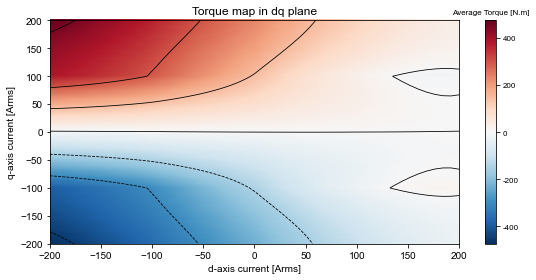

In [15]:
import matplotlib.pyplot as plt


# Init plot map
dict_map = {
    "Xdata": Id.reshape((n_Iq, n_Id))[0, :],
    "Ydata": Iq.reshape((n_Iq, n_Id))[:, 0],
    "xlabel": "d-axis current [Arms]",
    "ylabel": "q-axis current [Arms]",
    "type_plot": "pcolor",
    "is_contour": True,
#     "is_show_fig": is_show_fig,
}
# Plot torque maps
plot_3D(
    Zdata=Tem_interp.reshape((n_Iq, n_Id)).T,
    zlabel="Average Torque [N.m]",
    title="Torque map in dq plane",
   #save_path=join(save_path, name + "_torque_map.png"),
    **dict_map,
)
# plot 전압원 

plt.contour(
    dict_map["Xdata"],
    dict_map["Ydata"],
    U_max_interp.reshape((n_Iq, n_Id)),
    colors="blue",
    linewidths=0.8,
)
# plot_3D(
#     Zdata=Id.reshape((n_Iq, n_Id)).T,
#     zlabel="Average Torque [N.m]",
#     title="Torque map in dq plane",
#     # save_path=join(save_path, name + "_torque_map.png"),
#     **dict_map,
# )
# plot_3D(
#     Zdata=Iq.reshape((n_Iq, n_Id)).T,
#     zlabel="Average Torque [N.m]",
#     title="Torque map in dq plane",
#     # save_path=join(save_path, name + "_torque_map.png"),
# #     **dict_map,
# )



## 자속맵 (dq평면)

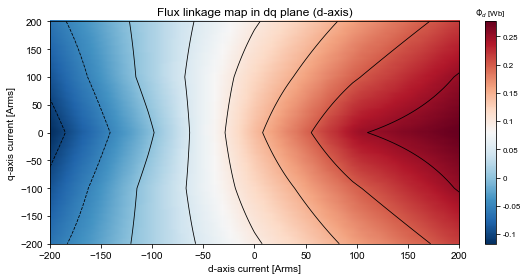

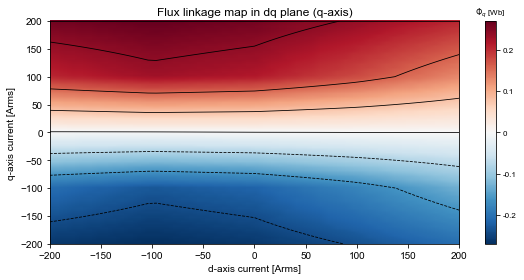

In [16]:


# Plot Phi_d map
plot_3D(
    Zdata=elec_model.eec.parameters["Phid"].reshape((n_Iq, n_Id)).T,
    zlabel="$\Phi_d$ [Wb]",
    title="Flux linkage map in dq plane (d-axis)",
    #save_path=join(save_path, name + "_phid_map.png"),
    **dict_map,
)

# Plot Phi_q map
plot_3D(
    Zdata=elec_model.eec.parameters["Phiq"].reshape((n_Iq, n_Id)).T,
    zlabel="$\Phi_q$ [Wb]",
    title="Flux linkage map in dq plane (q-axis)",
    #save_path=join(save_path, name + "_phiq_map.png"),
    **dict_map,
)

# plot_3D(
#     Zdata=Tem_sync.reshape((n_Iq, n_Id)).T,
#     zlabel="Synchrnous Torque [N.m]",
#     title="Torque map in dq plane",
#     #save_path=join(save_path, name + "_torque_sync_map.png"),
#     **dict_map,
# )
# plot_3D(
#     Zdata=Tem_rel.reshape((n_Iq, n_Id)).T,
#     zlabel="Reluctant Torque [N.m]",
#     title="Torque map in dq plane",
#     #save_path=join(save_path, name + "_torque_rel_map.png"),
#     **dict_map,
# )

## MTPA 계산을 통한 TN curve 작성 

Speed 1/50
Speed 2/50
Speed 3/50
Speed 4/50
Speed 5/50
Speed 6/50
Speed 7/50
Speed 8/50
Speed 9/50
Speed 10/50
Speed 11/50
Speed 12/50
Speed 13/50
Speed 14/50
Speed 15/50
Speed 16/50
Speed 17/50
Speed 18/50
Speed 19/50
Speed 20/50
Speed 21/50
Speed 22/50
Speed 23/50
Speed 24/50
Speed 25/50
Speed 26/50
Speed 27/50
Speed 28/50
Speed 29/50
Speed 30/50
Speed 31/50
Speed 32/50
Speed 33/50
Speed 34/50
Speed 35/50
Speed 36/50
Speed 37/50
Speed 38/50
Speed 39/50
Speed 40/50
Speed 41/50
Speed 42/50
Speed 43/50
Speed 44/50
Speed 45/50
Speed 46/50
Speed 47/50
Speed 48/50
Speed 49/50
Speed 50/50


C:\Users\user\.conda\envs\py38_pylee_backup\lib\site-packages\scidatatool-1.4.25-py3.8.egg\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\user\.conda\envs\py38_pylee_backup\lib\site-packages\scidatatool-1.4.25-py3.8.egg\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\user\.conda\envs\py38_pylee_backup\lib\site-packages\scidatatool-1.4.25-py3.8.egg\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


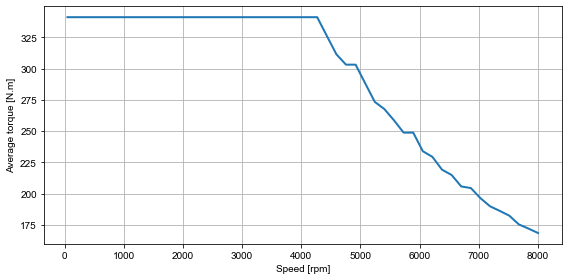

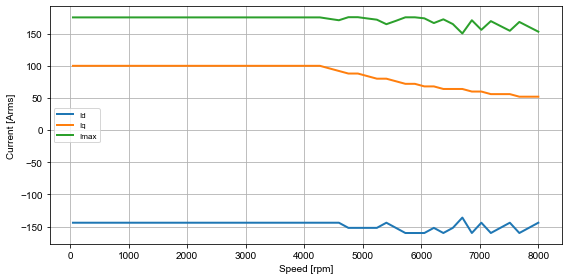

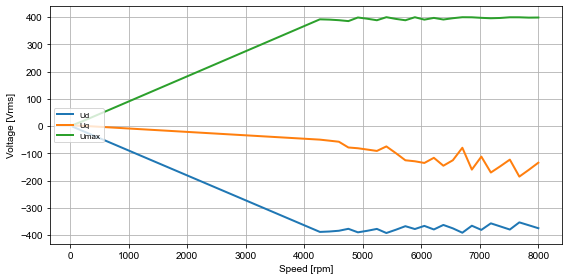

In [38]:


# Maximum current [Arms]
I_max = 250 / np.sqrt(2)
# Maximum voltage [Vrms]
U_max = 400
# Speed vector
Nspeed = 50
N0_min = 50
N0_max = 8000
N0_vect = np.linspace(N0_min, N0_max, Nspeed)
# Maximum load vector
Ntorque = 1
is_braking = False  # True to include negative torque (braking)

if is_braking:
    Ntorque = (
        2 * Ntorque + 1
    )  # Take twice the number of torques + odd to include zero torque
if not is_braking and Ntorque == 1:
    I_max_vect = np.array([I_max])
elif is_braking:
    I_max_vect = np.linspace(-I_max, I_max, Ntorque)
else:
    I_max_vect = np.linspace(0, I_max, Ntorque)

# Init OP_matrix
OP_matrix_MTPA = np.zeros((Nspeed, Ntorque, 4))
U_MTPA = np.zeros((Nspeed, Ntorque, 3))
I_MTPA = np.zeros((Nspeed, Ntorque, 3))

for ii, N0 in enumerate(N0_vect):

    print("Speed " + str(ii + 1) + "/" + str(Nspeed))

    # Update operating point
    OP_ref.N0 = N0
    OP_ref.felec = None

    # Update stator resistance with skin effect
    elec_model.eec.comp_parameters(
        Toyota_Prius,
        OP=OP_ref,
        Tsta=elec_model.Tsta,
        Trot=elec_model.Trot,
    )

    # Calculate voltage
    out_dict = elec_model.eec.solve()
    U_max_interp = np.sqrt(out_dict["Ud"] ** 2 + out_dict["Uq"] ** 2)
    
# ii는 속도의 인덱스
## kk는 토크 인덱스
# j0는 현재 index
# jmax는 MTPA 토크

    for kk, I_max0 in enumerate(I_max_vect):

        if I_max0 == 0:
            # Finding indices of operating points satisfying Vmax voltage for Iq=0 (no torque production)
            j0 = np.logical_and(U_max_interp <= U_max, np.abs(Iq) == 0)

            # Finding index of operating point giving lowest current
            jmax = np.argmin(np.abs(Imax_interp[j0]))

        else:
            # Finding indices of operating points satisfying Vmax and XImax(i) voltage and torque limitations
            j0 = np.logical_and(
                U_max_interp <= U_max, Imax_interp <= np.abs(I_max0)
            )

            if I_max0 > 0:
                # Finding index of operating point giving maximum positive torque among feasible operating points
                jmax = np.argmax(Tem_interp[j0])
            else:
                # Finding index of operating point giving maximum negative torque among feasible operating points
                jmax = np.argmin(Tem_interp[j0])

        # Store values in MTPA
        OP_matrix_MTPA[ii, kk, 0] = N0
        OP_matrix_MTPA[ii, kk, 1] = Id[j0][jmax]
        OP_matrix_MTPA[ii, kk, 2] = Iq[j0][jmax]
        OP_matrix_MTPA[ii, kk, 3] = Tem_interp[j0][jmax]
        U_MTPA[ii, kk, 0] = out_dict["Ud"][j0][jmax]
        U_MTPA[ii, kk, 1] = out_dict["Uq"][j0][jmax]
        U_MTPA[ii, kk, 2] = U_max_interp[j0][jmax]
        I_MTPA[ii, kk, 0] = OP_matrix_MTPA[ii, kk, 1]
        I_MTPA[ii, kk, 1] = OP_matrix_MTPA[ii, kk, 2]
        I_MTPA[ii, kk, 2] = Imax_interp[j0][jmax]

if Ntorque == 1:
    # Plot torque speed curve for each load level
    y_list = list()
    legend_list = list()
    for i_load in range(Ntorque):
        y_list.append(OP_matrix_MTPA[:, i_load, 3])
        #legend_list.append(
        #    "Load level = " + str(int(round(100 * (i_load) / (Ntorque - 1)))) + " %"
        #)
    plot_2D(
        [OP_matrix_MTPA[:, i_load, 0]],
        y_list,
        xlabel="Speed [rpm]",
        ylabel="Average torque [N.m]",
        legend_list=legend_list,
#         save_path=join(save_path, name + "_MTPA_torque_speed.png"),
#         is_show_fig=is_show_fig,
    )
if Ntorque > 1:
    # Plot torque speed curve for each load level
    y_list = list()
    legend_list = list()
    for i_load in range(Ntorque):
        y_list.append(OP_matrix_MTPA[:, i_load, 3])
        #legend_list.append(
        #    "Load level = " + str(int(round(100 * (i_load) / (Ntorque - 1)))) + " %"
        #)
    plot_2D(
        [OP_matrix_MTPA[:, i_load, 0]],
        y_list,
        xlabel="Speed [rpm]",
        ylabel="Average torque [N.m]",
        legend_list=legend_list,
#         save_path=join(save_path, name + "_MTPA_torque_speed.png"),
#         is_show_fig=is_show_fig,
    )


i_load = -1

plot_2D(
    [OP_matrix_MTPA[:, i_load, 0]],
    [I_MTPA[:, i_load, 0], I_MTPA[:, i_load, 1], I_MTPA[:, i_load, 2]],
    xlabel="Speed [rpm]",
    ylabel="Current [Arms]",
    legend_list=["Id", "Iq", "Imax"],
#     save_path=join(save_path, name + "_current_MTPA_OP" + str(i_load) + ".png"),
#     is_show_fig=is_show_fig,
)

plot_2D(
    [OP_matrix_MTPA[:, i_load, 0]],
    [U_MTPA[:, i_load, 0], U_MTPA[:, i_load, 1], U_MTPA[:, i_load, 2]],
    xlabel="Speed [rpm]",
    ylabel="Voltage [Vrms]",
    legend_list=["Ud", "Uq", "Umax"],
#     save_path=join(save_path, name + "_voltage_MTPA_OP" + str(i_load) + ".png"),
#     is_show_fig=is_show_fig,
)



In [19]:
i_load
Ntorque
print(I_max_vect)
print(abs(I_max_vect))

[176.7766953]
[176.7766953]


# Force 계산

In [1]:
from numpy import exp, sqrt, pi
from os.path import join
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.ForceMT import ForceMT
from pyleecan.Classes.Output import Output
from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR
from pyleecan.Classes.OPdq import OPdq

# Load the machine
Toyota_Prius = load(join(DATA_DIR, "Machine", "Toyota_Prius.json"))

# Simulation initialization
simu = Simu1(name="FEMM_periodicity", machine=Toyota_Prius)


simu.input = InputCurrent(
#    Na_tot=252 * 8,
#    Nt_tot=50 * 8,
    Na_tot=5 * 2 ** 8, Nt_tot=120
)
# Set Id/Iq according to I0/Phi0
simu.input.OP = OPdq(N0=1000)
simu.input.OP.set_I0_Phi0(I0=250 / sqrt(2), Phi0=140*pi/180)

# Definition of the magnetic simulation: with periodicity
simu.mag = MagFEMM(is_periodicity_a=True, is_periodicity_t=True, nb_worker=12)
simu.force = ForceMT(is_periodicity_a=True, is_periodicity_t=True,is_agsf_transfer=True,max_wavenumber_transfer=96)

# Run simulations
out = simu.run()

[20:51:35] Starting running simulation FEMM_periodicity (machine=Toyota_Prius)
[20:51:35] Starting Magnetic module
[20:51:35] Solving time step 1 / 15 in FEMM
[20:51:36] Solving time step 10 / 15 in FEMM
[20:51:36] Solving time step 5 / 15 in FEMM
[20:51:36] Solving time step 3 / 15 in FEMM
[20:51:36] Solving time step 8 / 15 in FEMM
[20:51:36] Solving time step 9 / 15 in FEMM
[20:51:36] Solving time step 11 / 15 in FEMM
[20:51:36] Solving time step 7 / 15 in FEMM
[20:51:36] Solving time step 2 / 15 in FEMM
[20:51:37] Solving time step 15 / 15 in FEMM
[20:51:37] Solving time step 6 / 15 in FEMM
[20:51:37] Solving time step 13 / 15 in FEMM
[20:51:37] Solving time step 4 / 15 in FEMM
[20:51:37] Solving time step 14 / 15 in FEMM
[20:51:38] Solving time step 12 / 15 in FEMM
[20:51:38] Starting Force module
[20:51:38] End of simulation FEMM_periodicity


C:\Users\user\.conda\envs\py38_pylee_backup\lib\site-packages\scidatatool-1.4.25-py3.8.egg\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\user\.conda\envs\py38_pylee_backup\lib\site-packages\scidatatool-1.4.25-py3.8.egg\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


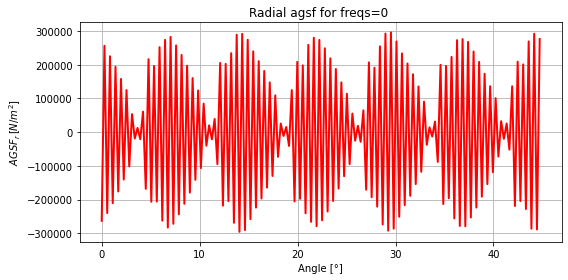

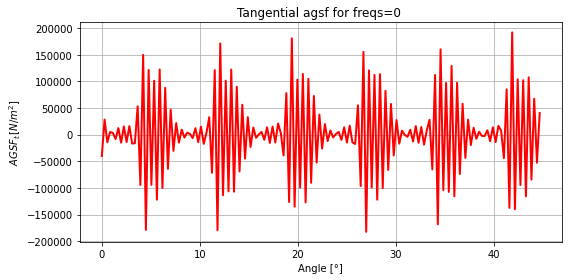

In [3]:
from pyleecan.Functions.Plot import dict_2D, dict_2D
#a=simu.parent.force
#a.AGSF.plot_2D_Data("angle",**dict_2D)
out.force.AGSF.plot_2D_Data("angle{°}", **dict_2D)

In [4]:
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.ForceMT import ForceMT

# Create the Simulation
mySimu = Simu1(name="Tuto_Force")  
mySimu.parent = out
mySimu.force = ForceMT()

# Run only the force module
out_mySimu=mySimu.force.run()
   

[20:52:09] Starting Force module


In [5]:
mySimu.parent.force.AGSF

C:\Users\user\.conda\envs\py38_pylee_backup\lib\site-packages\scidatatool-1.4.25-py3.8.egg\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\user\.conda\envs\py38_pylee_backup\lib\site-packages\scidatatool-1.4.25-py3.8.egg\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


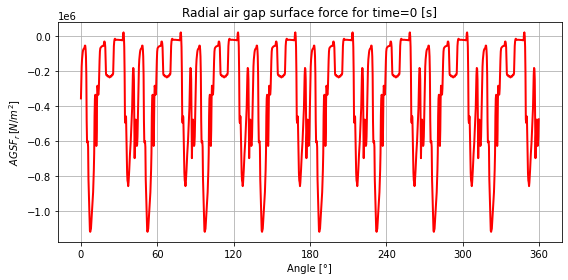

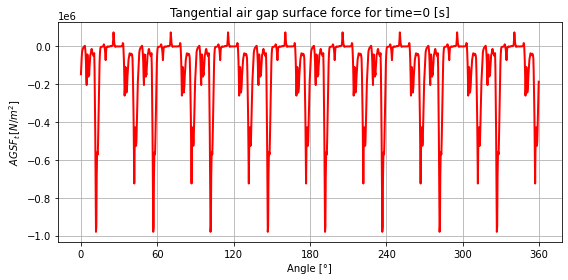

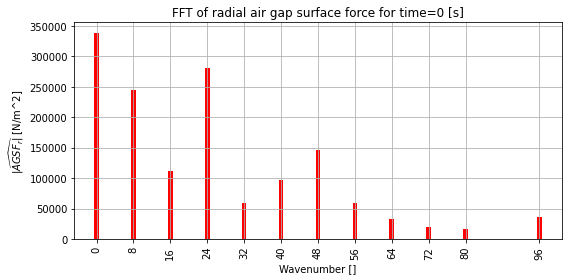

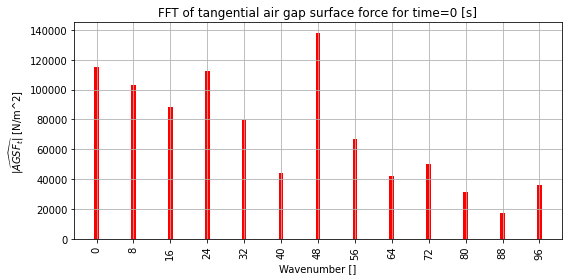

In [6]:
mySimu.parent.force.AGSF.plot_2D_Data("angle{°}", **dict_2D)
mySimu.parent.force.AGSF.plot_2D_Data("wavenumber=[0,96]", **dict_2D)

Once the simulation is finished, the results are stored in the force part of the output (i.e. _myResults.force_ ) and we can call different plots. This object contains:   
- *Time*: Time axe
- *Angle*: Angular position axe   
- *AGSF*: Airgap surface force (Radial and Tangential component)
    
**Output** object embbed different plot to visualize results easily. You can find a dedicated tutorial [here](https://www.pyleecan.org/tuto_Plots.html).

Here are some example of useful plots.

In [12]:
from pyleecan.Functions.Plot import dict_2D, dict_3D
#axis_data=out.force.AGSF.get_axes()

#out.force.AGSF.plot_2D_Data_Animated("time",save_path="D:/AGSF.gif")
#("freqs", "angle[0]")
#out.force.AGSF.plot_2D_Data("angle{°}", **dict_2D)
#out.force.AGSF.plot_2D_Data("wavenumber=[0,78]", **dict_2D)

In [13]:
axis_data=[]

In [10]:
from numpy import pi

#------------------------------------------------------
# Plot the air-gap force as a function of time with the time fft
out.force.AGSF.plot_2D_Data("time","angle[10]", is_auto_ticks=False, **dict_2D)
out.force.AGSF.plot_2D_Data("freqs=[0,4000]", is_auto_ticks=False, **dict_2D)
#------------------------------------------------------

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following plot displays the radial air-gap surface force over time and angle. 

In [15]:
#------------------------------------------------------
# Plot the tangential force as a function of time and space
out.force.AGSF.plot_3D_Data("time", "angle{°}", is_2D_view=True,x_max=0.06, **dict_3D)
out.force.AGSF.plot_3D_Data("time", "angle{°}", is_2D_view=False, **dict_3D)
#------------------------------------------------------

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
out.mag.B.plot_3D_Data("mag.B", "freqs","wavenumber", component_list=['radial'], is_2D_view=False)

AxisError: axis 1 is out of bounds for array of dimension 1

<IPython.core.display.Javascript object>


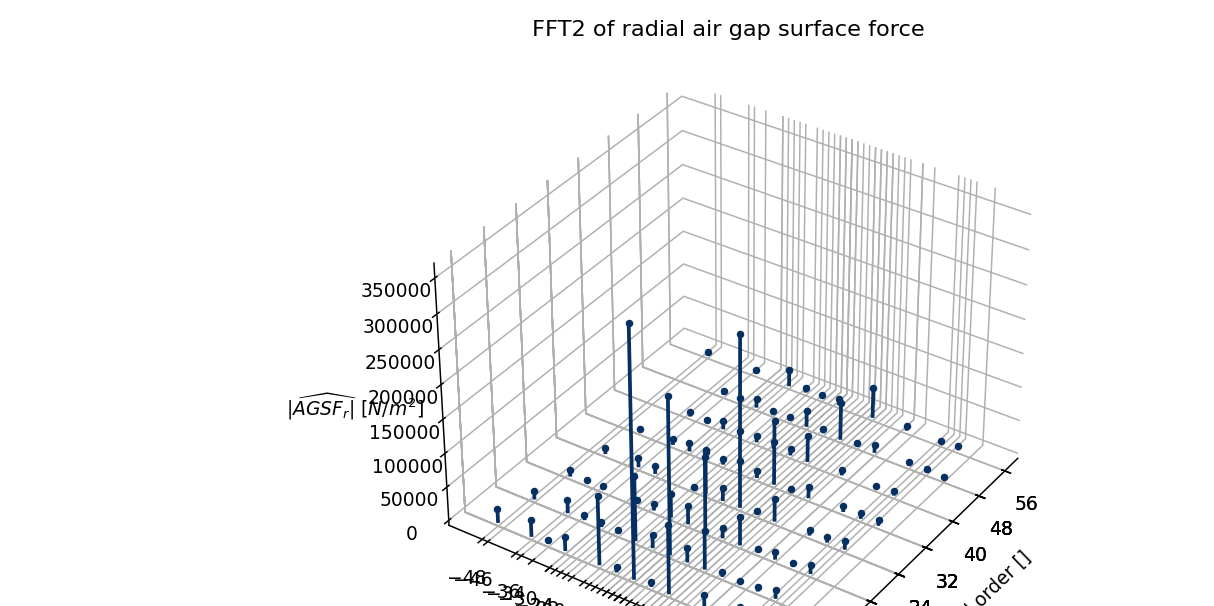

In [111]:
out.force.AGSF.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber->space_order=[-48,48]",
    N_stem=100,
    
    component_list=["radial"],
    is_2D_view=False,
    **dict_3D

)

In [119]:
I_max_vect = np.array([I_max])
I_max_vect

array([176.7766953])

In [121]:
N0_vect.size

50